# Data generation


In [1]:
import numpy as np

def generate_data(n, d, rho, eta, seed=0):
    rng = np.random.default_rng(seed)
    
    # 1) Construction de mu_1 et mu_2
    v1 = rng.normal(size=d)
    v1 /= np.linalg.norm(v1)
    v2 = rng.normal(size=d)
    v2 -= (v2 @ v1) * v1
    v2 /= np.linalg.norm(v2)
    mu_1 = rho * v1
    mu_2 = rho * v2

    # 2) Construction de la matrice de covariance
    I_d = np.eye(d)
    Sigma = I_d - (np.outer(mu_1, mu_1) + np.outer(mu_2, mu_2)) / (rho**2)

    # 3) Génération aléatoire des labels
    y = rng.choice([+1, -1], size=n)

    # 4) Génération bruit + signal
    # Utilisons le rng local pour multivariate_normal
    noise = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)
    
    # mu_1 si y = +1, mu_2 si y = -1
    # (n, d), en faisant un simple broadcast
    signals = np.where(y[:, None] == 1, mu_1, mu_2)

    # 5) Assignation aux tokens
    X = np.empty((n, 2, d), dtype=float)
    token_choices = rng.integers(low=0, high=2, size=n)
    X[np.arange(n), token_choices, :] = signals
    X[np.arange(n), 1 - token_choices, :] = noise

    # 6) Flip des étiquettes avec probabilité eta
    rng_flip = np.random.default_rng(seed + 1)
    flip_mask = rng_flip.random(n) < eta
    y_flipped = y.copy()
    y_flipped[flip_mask] = -y_flipped[flip_mask]

    # 7) Indices
    clean_indices = np.where(~flip_mask)[0]
    noisy_indices = np.where(flip_mask)[0]

    return X, y_flipped, clean_indices, noisy_indices


# Single head attention


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    """
    Implements f(X; p, v) = v^T X^T softmax(X p),
    where X is (batch_size, 2, d),
          p, v are (d,).
    """
    def __init__(self, d):
        super().__init__()
        # Initialize trainable parameters p and v in R^d
        self.p = nn.Parameter(torch.randn(d) * 0.01)
        self.v = nn.Parameter(torch.randn(d) * 0.01)

    def forward(self, X):
        # 1) Compute the raw "logits" for attention: X p
        #    shape: (batch_size, 2, d) @ (d,) -> (batch_size, 2)
        logits = X @ self.p  # or torch.matmul(X, self.p)
        
        # 2) Apply softmax across the two tokens (dim=1)
        #    shape: (batch_size, 2)
        attn_weights = F.softmax(logits, dim=1)
        
        # 3) Compute the weighted sum of the 2 tokens:
        #  (batch_size, d)
        weighted_sum = (attn_weights.unsqueeze(-1) * X).sum(dim=1)
        
        # 4) Now take dot product with v for each sample
        #    shape: (batch_size,)
        output = (weighted_sum * self.v).sum(dim=1)

        return output



# Metrics and loss

In [4]:
def logistic_loss_fn(logits, labels):
    """
    Compute average logistic loss for binary classification w/ labels in {+1,-1}.
    Logistic loss = mean[ log(1 + exp(-y * z)) ]
      - logits = z
      - labels = y in {+1, -1}
    """
    return torch.mean(torch.log(1.0 + torch.exp(-labels * logits)))


def accuracy_score(logits, labels):
    """
    Classification accuracy when thresholding logits at 0, 
    with labels in {+1, -1}.
    """
    preds = torch.sign(logits)  # get +1 or -1
    correct = (preds == labels).sum().item()
    return correct / len(labels)


In [5]:
import matplotlib.pyplot as plt

def plot_metrics(train_acc, test_acc, clean_probs, noisy_probs):
    """
    Plot the metrics during training: train/test accuracies and softmax probabilities.
    
    Parameters:
    - train_acc: List of train accuracies.
    - test_acc: List of test accuracies.
    - clean_probs: List of softmax probabilities for clean samples.
    - noisy_probs: List of softmax probabilities for noisy samples.
    """
    # Plot Train and Test Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_acc)), train_acc, label='Train Accuracy')
    plt.plot(range(len(test_acc)), test_acc, label='Test Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy during Training')
    plt.legend()

    # Plot Softmax Probabilities for Clean and Noisy Samples
    plt.subplot(1, 2, 2)
    plt.plot(range(len(clean_probs)), clean_probs, label='Clean Sample Probabilities')
    plt.plot(range(len(noisy_probs)), noisy_probs, label='Noisy Sample Probabilities')
    plt.xlabel('Iteration')
    plt.ylabel('Softmax Probability')
    plt.title('Softmax Probability of Signal Token')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training the model


In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
        device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [9]:
import matplotlib.pyplot as plt
batch_size = 50   # mini-batch
n_train   = 40
n_test    = 40
d         = 6000
rho       = 5.0
eta       = 0.1
beta      = 0.025  
num_steps = 150
log_every = 10



X_train_np, y_train_np, clean_indices_train, noisy_indices_train = generate_data(n_train, d, rho, eta= 0.1)
X_test_np,  y_test_np, clean_indices_test, noisy_indices_test = generate_data(n_test, d, rho, eta= 0.1)


X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test_np, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_np, dtype=torch.float32, device=device)


X_train[clean_indices_train].shape

torch.Size([37, 2, 6000])

Epoch=1 done
Epoch=10 done
Epoch=20 done
Epoch=30 done
Epoch=40 done
Epoch=50 done
Epoch=60 done
Epoch=70 done
Epoch=80 done
Epoch=90 done
Epoch=100 done
Epoch=110 done
Epoch=120 done
Epoch=130 done
Epoch=140 done
Epoch=150 done


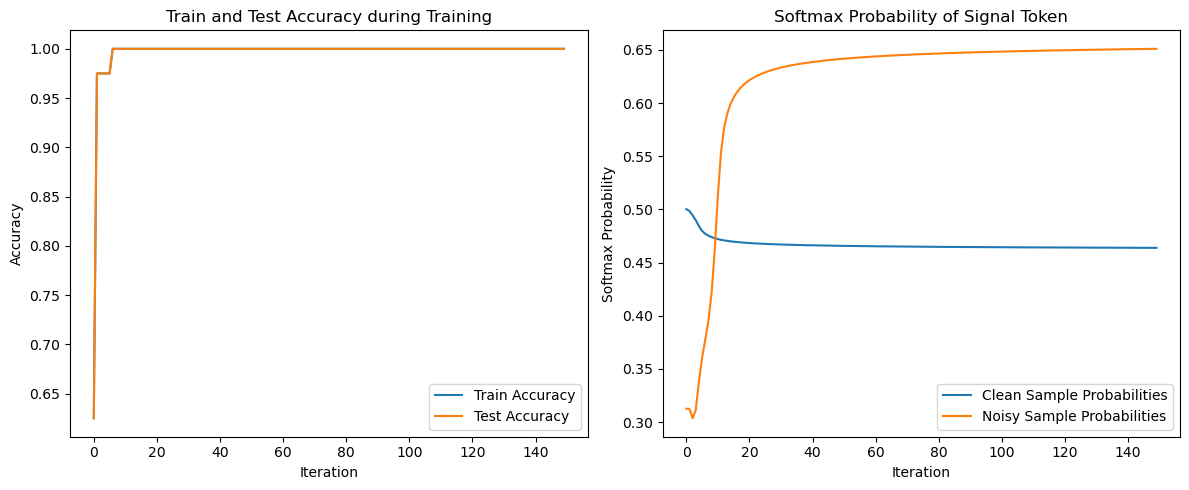

In [12]:
num_steps = 150

model = SingleHeadAttention(d).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=beta)

train_accs = []
test_accs  = []
steps_list = []

clean_proba = []
noisy_proba = []


cur_step = 0
for epoch in range(num_steps):
    pred = model(X_train)
    loss = logistic_loss_fn(pred, y_train)

    # Backprop
    #optimizer.zero_grad()
    model.zero_grad()
    with torch.no_grad():
        # Prédictions sur train complet
        pred = model(X_train)
        train_acc = accuracy_score(pred, y_train)
        # Prédictions sur test
        logits_test = model(X_test)
        test_acc = accuracy_score(logits_test, y_test)
        
        logits_clean = torch.matmul(X_train[clean_indices_train], model.p)  # Ajustez selon la forme de model.p
        probs_clean = F.softmax(logits_clean, dim=1)[:, 0].cpu().numpy()
        clean_probs_iter = np.mean(probs_clean)

        logits_noisy = torch.matmul(X_train[noisy_indices_train], model.p)  # Ajustez selon la forme de model.p
        probs_noisy = F.softmax(logits_noisy, dim=1)[:, 0].cpu().numpy()
        noisy_probs_iter = np.mean(probs_noisy)


        # clean_probs_iter = np.mean(F.softmax(np.dot((X_train[clean_indices_train], model.p).cpu()))[:, 0])
        # noisy_probs_iter = np.mean(F.softmax(np.dot((X_train[noisy_indices_train], model.p).cpu()))[:, 0])


    train_accs.append(train_acc)
    test_accs.append(test_acc)
    steps_list.append(cur_step)
    clean_proba.append(clean_probs_iter)
    noisy_proba.append(noisy_probs_iter)




    loss.backward()
    #optimizer.step()
    
    with torch.no_grad():
        for param in model.parameters():
            param -= beta * param.grad
        
    # Logging tous les epochs
    cur_step += 1
    if (epoch==0) or (epoch+1)%log_every==0 or (epoch+1 == num_steps):

        print(f"Epoch={epoch+1} done")


plot_metrics(train_accs, test_accs, clean_proba, noisy_proba)
